In [0]:
!pip install git+https://github.com/gbaydin/hypergradient-descent.git

  Cloning https://github.com/gbaydin/hypergradient-descent.git to /tmp/pip-req-build-e9gt0o7b
  Running command git clone -q https://github.com/gbaydin/hypergradient-descent.git /tmp/pip-req-build-e9gt0o7b
  Created wheel for hypergrad: filename=hypergrad-0.1-cp36-none-any.whl size=8188 sha256=fff2ffd89be83ebc035bc470edf87c096f893bdb1e2e9f2ff65b7146e0e39163
  Stored in directory: /tmp/pip-ephem-wheel-cache-b5rqd5x4/wheels/fd/a2/2d/63c4e652ba00bf75e1e0e9ce9628cb47c151bd10322a6cf978
Successfully built hypergrad


In [0]:
import torch
! pip install torchbearer
import torchbearer

     |████████████████████████████████| 143kB 13.8MB/s 


In [0]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import DataLoader
from hypergrad import SGDHD, AdamHD

In [0]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x : x.view(-1))])

train = MNIST('.', train=True, transform=transform, download=True)
test = MNIST('.', train=False, transform=transform, download=True)

trainloader = DataLoader(train, batch_size=128, shuffle=True)
testloader = DataLoader(test, batch_size=128, shuffle=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!





/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
class NeuralNet(nn.Module) :
    def __init__(self) :
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(784,1000)
        self.fc2 = nn.Linear(1000,1000)
        self.fc3 = nn.Linear(1000, 10)
    def forward(self, x) :
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        return out

In [0]:
alpha = 0.001
beta = 0.001
b = 1e-7
w_decay = 0.0001
mu = 0.9

In [0]:
device = 'cuda:0'
model1 = NeuralNet().to(device) #SGD
model2 = NeuralNet().to(device) #SGDHD
model3 = NeuralNet().to(device) #SGDN
model4 = NeuralNet().to(device) #SGDNHD
model5 = NeuralNet().to(device) #Adam
model6 = NeuralNet().to(device) #AdamHD
opt1 = optim.SGD(model1.parameters(), lr=alpha, weight_decay=w_decay)
opt2 = SGDHD(model2.parameters(), lr=alpha, weight_decay=w_decay, hypergrad_lr=beta)
opt3 = optim.SGD(model3.parameters(), lr=alpha, weight_decay=w_decay, momentum=mu,nesterov=True)
opt4 = SGDHD(model4.parameters(), lr=alpha, weight_decay=w_decay, hypergrad_lr=beta, momentum=mu, nesterov=True)
opt5 = optim.Adam(model5.parameters(), lr=alpha, weight_decay=w_decay)
opt6 = AdamHD(model6.parameters(), lr=alpha, hypergrad_lr=b, weight_decay=w_decay)

In [0]:
import time
def run_trial(model, opt, loss_func, epoch) :
    start = time.time()
    losses = []
    learn = []
    for i in range(epoch) :
        ep_loss = 0
        va_loss = 0
        alpha = 0
        for _, (data, label) in enumerate(trainloader) :
            data = data.to(device)
            label = label.to(device)
            opt.zero_grad()
            out = model(data)
            loss = loss_func(out, label)
            loss.backward()
            opt.step()
            a = opt.param_groups[0]['lr']
            alpha += a
            loss = loss.data
            ep_loss += loss
        for _, (data, label) in enumerate(testloader) :
            data = data.to(device)
            label = label.to(device)
            out = model(data)
            loss = loss_func(out, label)
            va_loss += loss.data
        learn.append(alpha/len(trainloader.dataset))
        losses.append((ep_loss/len(trainloader.dataset),va_loss/len(testloader.dataset)))
    finish = time.time()
    return losses, finish - start, learn

In [0]:
sgd, timesgd, lrsgd = run_trial(model1, opt1, F.cross_entropy, 100)
sgdhd, timesgdhd, lrsgdhd = run_trial(model2, opt2, F.cross_entropy, 100)
sgdn, timesgdn, lrsgdn = run_trial(model3, opt3, F.cross_entropy, 100)
sgdnhd, timesgdnhd, lrsgdnhd = run_trial(model4, opt4, F.cross_entropy, 100)
adam, timeadam, lradam = run_trial(model5, opt5, F.cross_entropy, 100)
adamhd, timeadamhd, lradamhd = run_trial(model6, opt6, F.cross_entropy, 100)

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


In [0]:
sgd = torch.Tensor(sgd)
sgdhd = torch.Tensor(sgdhd)
sgdn = torch.Tensor(sgdn)
sgdnhd = torch.Tensor(sgdnhd)
adam = torch.Tensor(adam)
adamhd = torch.Tensor(adamhd)

Text(0.5, 0.98, 'MLP')

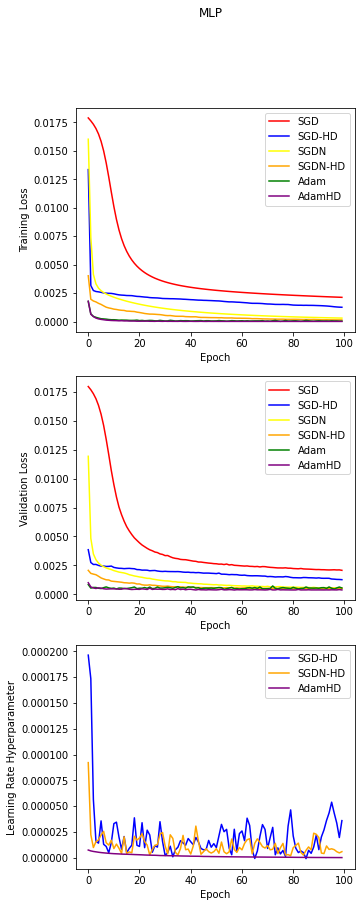

In [0]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(5,14))
ax[0].plot(range(100),sgd[:,0],color='red')
ax[0].plot(range(100),sgdhd[:,0],color='blue')
ax[0].plot(range(100),sgdn[:,0],color='yellow')
ax[0].plot(range(100),sgdnhd[:,0],color='orange')
ax[0].plot(range(100),adam[:,0],color='green')
ax[0].plot(range(100),adamhd[:,0],color='purple')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Training Loss')
ax[0].legend(['SGD', 'SGD-HD', 'SGDN', 'SGDN-HD', 'Adam', 'AdamHD'])
ax[1].plot(range(100),sgd[:,1],color='red')
ax[1].plot(range(100),sgdhd[:,1],color='blue')
ax[1].plot(range(100),sgdn[:,1],color='yellow')
ax[1].plot(range(100),sgdnhd[:,1],color='orange')
ax[1].plot(range(100),adam[:,1],color='green')
ax[1].plot(range(100),adamhd[:,1],color='purple')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Validation Loss')
ax[1].legend(['SGD', 'SGD-HD', 'SGDN', 'SGDN-HD', 'Adam', 'AdamHD'])
ax[2].plot(range(100),lrsgdhd,color='blue')

ax[2].plot(range(100),lrsgdnhd,color='orange')

ax[2].plot(range(100),lradamhd,color='purple')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Learning Rate Hyperparameter')
ax[2].legend(['SGD-HD', 'SGDN-HD', 'AdamHD'])
fig.suptitle('MLP')